In [1]:
# Core
import warnings
from IPython.core.interactiveshell import InteractiveShell
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from pandas_profiling import ProfileReport
from sklearn.ensemble import RandomForestRegressor
from pandas import DataFrame

# Error metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import max_error as ME
from sklearn.metrics import mean_absolute_error as MAE

# Machine Learning 
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import RegressorChain
from sklearn.datasets import make_regression
import xgboost as xgb

#Scalers
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# Time series split for cross validation 
from sklearn.model_selection import TimeSeriesSplit

# Optimization
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Others
import math

import sys
sys.path.append('../')
from utils import ML
from project_core.reporting.utils import get_style_file_path

In [2]:
# Core setting for print, warning and plotting
pd.set_option('display.max_columns', None)
InteractiveShell.ast_node_interactivity = "all" # Allow multiple outputs in the same cell
warnings.filterwarnings("ignore") # Ignore warnings
plt.style.use(get_style_file_path())

rcParams['figure.figsize'] = 16, 6 # Set the standard plot size
%matplotlib inline

In [3]:
target = 'GHI'

In [4]:
solar = pd.read_csv('../data/NASA_Dataset_Cleaned.csv', index_col = 'DATETIME', parse_dates=['DATETIME', 'DATETIME'])

In [5]:
vars_to_drop = ['DNI', 'DHI','GHI']
vars_to_drop.remove(target)
solar.drop(labels=vars_to_drop, axis=1,inplace=True)


# Load the model

In [6]:
import xgboost as xgb

xgbtunedreg = xgb.Booster()
xgbtunedreg.load_model("xgb_model_GHI.json")

In [7]:
# def create_features(df):
#     """
#     Creates time series features from datetime index
#     """
#     df['date'] = df.index
#     df['hour'] = df['date'].dt.hour
#     df['dayofweek'] = df['date'].dt.dayofweek
#     df['quarter'] = df['date'].dt.quarter
#     df['month'] = df['date'].dt.month
#     df['year'] = df['date'].dt.year
#     df['dayofyear'] = df['date'].dt.dayofyear
#     df['dayofmonth'] = df['date'].dt.day
#     df['weekofyear'] = df['date'].dt.weekofyear

#     df[f'{target}_6_hrs_lag'] = df[f'{target}'].shift(6)
#     df[f'{target}_12_hrs_lag'] = df[f'{target}'].shift(12)
#     df[f'{target}_24_hrs_lag'] = df[f'{target}'].shift(24)

#     df[f'{target}_6_hrs_mean'] = df[f'{target}'].rolling(window = 6).mean()
#     df[f'{target}_12_hrs_mean'] = df[f'{target}'].rolling(window = 12).mean()
#     df[f'{target}_24_hrs_mean'] = df[f'{target}'].rolling(window = 24).mean()

#     df[f'{target}_6_hrs_std'] = df[f'{target}'].rolling(window = 6).std()
#     df[f'{target}_12_hrs_std'] = df[f'{target}'].rolling(window = 12).std()
#     df[f'{target}_24_hrs_std'] = df[f'{target}'].rolling(window = 24).std()

#     df[f'{target}_6_hrs_max'] = df[f'{target}'].rolling(window = 6).max()
#     df[f'{target}_12_hrs_max'] = df[f'{target}'].rolling(window = 12).max()
#     df[f'{target}_24_hrs_max'] = df[f'{target}'].rolling(window = 24).max()
    
#     df[f'{target}_6_hrs_min'] = df[f'{target}'].rolling(window = 6).min()
#     df[f'{target}_12_hrs_min'] = df[f'{target}'].rolling(window = 12).min()
#     df[f'{target}_24_hrs_min'] = df[f'{target}'].rolling(window = 24).min()
    
#     df.drop(columns=['date'], axis=1, inplace=True)

#     return df


In [8]:
def create_features(df):
  target_map = solar[target].to_dict()
  df['lag0'] = (df.index - pd.Timedelta('5 hours')).map(target_map)
  df['lag1'] = (df.index - pd.Timedelta('7 days')).map(target_map)
  df['lag2'] = (df.index - pd.Timedelta('8 days')).map(target_map)
  df['lag3'] = (df.index - pd.Timedelta('9 days')).map(target_map)
  df['lag4'] = (df.index - pd.Timedelta('10 days')).map(target_map)
  df['lag5'] = (df.index - pd.Timedelta('11 days')).map(target_map)
  df['lag6'] = (df.index - pd.Timedelta('12 days')).map(target_map)
  df['lag7'] = (df.index - pd.Timedelta('13 days')).map(target_map)
  df['lag8'] = (df.index - pd.Timedelta('364 days')).map(target_map)
  df['lag9'] = (df.index - pd.Timedelta('728 days')).map(target_map)
  df['lag10'] = (df.index - pd.Timedelta('1092 days')).map(target_map)  

  df['date'] = df.index
  df['hour'] = df['date'].dt.hour
  df['dayofweek'] = df['date'].dt.dayofweek
  df['quarter'] = df['date'].dt.quarter
  df['month'] = df['date'].dt.month
  df['year'] = df['date'].dt.year
  df['dayofyear'] = df['date'].dt.dayofyear
  df['dayofmonth'] = df['date'].dt.day
  df['weekofyear'] = df['date'].dt.weekofyear
  df.set_index('date', inplace=True)

  return df

In [9]:
import datetime as dt

START_DATE = dt.datetime(2021,12,28)
END_DATE   = dt.datetime(2022,1,4) 

START_TIME = dt.time(16,0,0,0)
END_TIME   = dt.time(16,0,0,0)

START = dt.datetime.combine(START_DATE, START_TIME)
END = dt.datetime.combine(END_DATE, END_TIME)

index = pd.date_range(start=solar.index[-1] + dt.timedelta(hours=1), end=END, freq='H')
columns = solar.columns
df = pd.DataFrame(index=index, columns=columns)
solar = pd.concat([solar, df])
solar = create_features(solar)
# not adding year variable here because the model will use the most recent lag energy consumption values
cols_to_transform = ['T2MDEW', 'DIFFUSE_ILLUMINANCE', 'DIRECT_ILLUMINANCE',
       'GLOBAL_ILLUMINANCE', 'RH2M', 'QV2M', 'PS', 'T2M', 'SZA', 'WS2M'] # other columns are binary values
scaler = StandardScaler()
solar[cols_to_transform] = scaler.fit_transform(solar[cols_to_transform])

test = solar[START:END]
y = test[target]
X = test.loc[:, ~test.columns.isin(['GHI', 'DHI', 'DNI'])]

X_DM = xgb.DMatrix(X)
y_DM = xgb.DMatrix(y)

In [10]:
preds_xgb_test = xgbtunedreg.predict(X_DM, ntree_limit=xgbtunedreg.best_ntree_limit)

# Results

In [11]:
import sys
sys.path.append('../')
from utils import ML
from project_core.reporting.utils import get_style_file_path

In [12]:
# dict_error = {}

In [13]:
# # Training Set
# dict_error = ML.error_metrics(
#     y_pred=preds_xgb_test, 
#     y_truth=y, 
#     model_name='Tuned XGBoost on Test Set', 
#     test=True, 
#     dict_error=dict_error)
# # RMSE: 15.56
# # R2: 1.00
# # MAE: 5.95

In [14]:
ML.plot_ts_pred(
    og_ts=y, 
    pred_ts=preds_xgb_test, 
    model_name='Tuned XGBoost on Test Set')

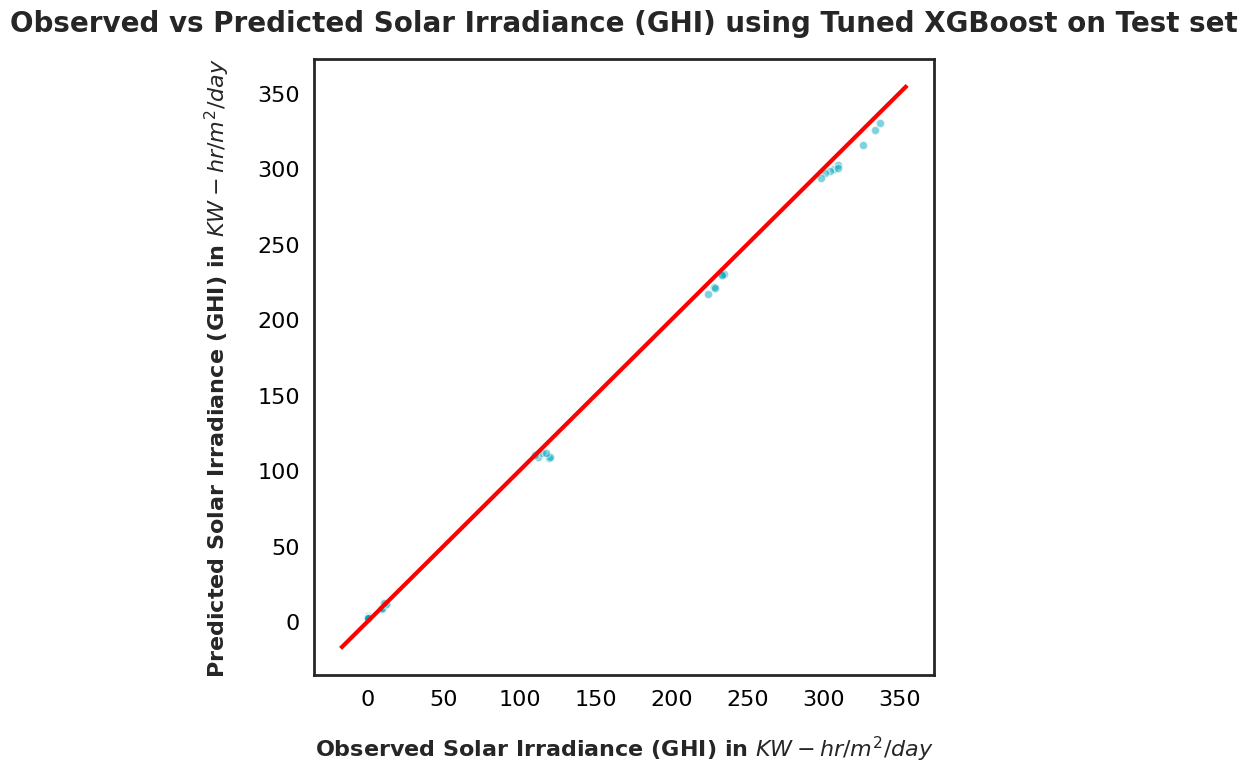

In [15]:
ML.plot_predvstrue_reg(
    pred=preds_xgb_test, 
    truth=y, 
    model_name='Tuned XGBoost on Test set')

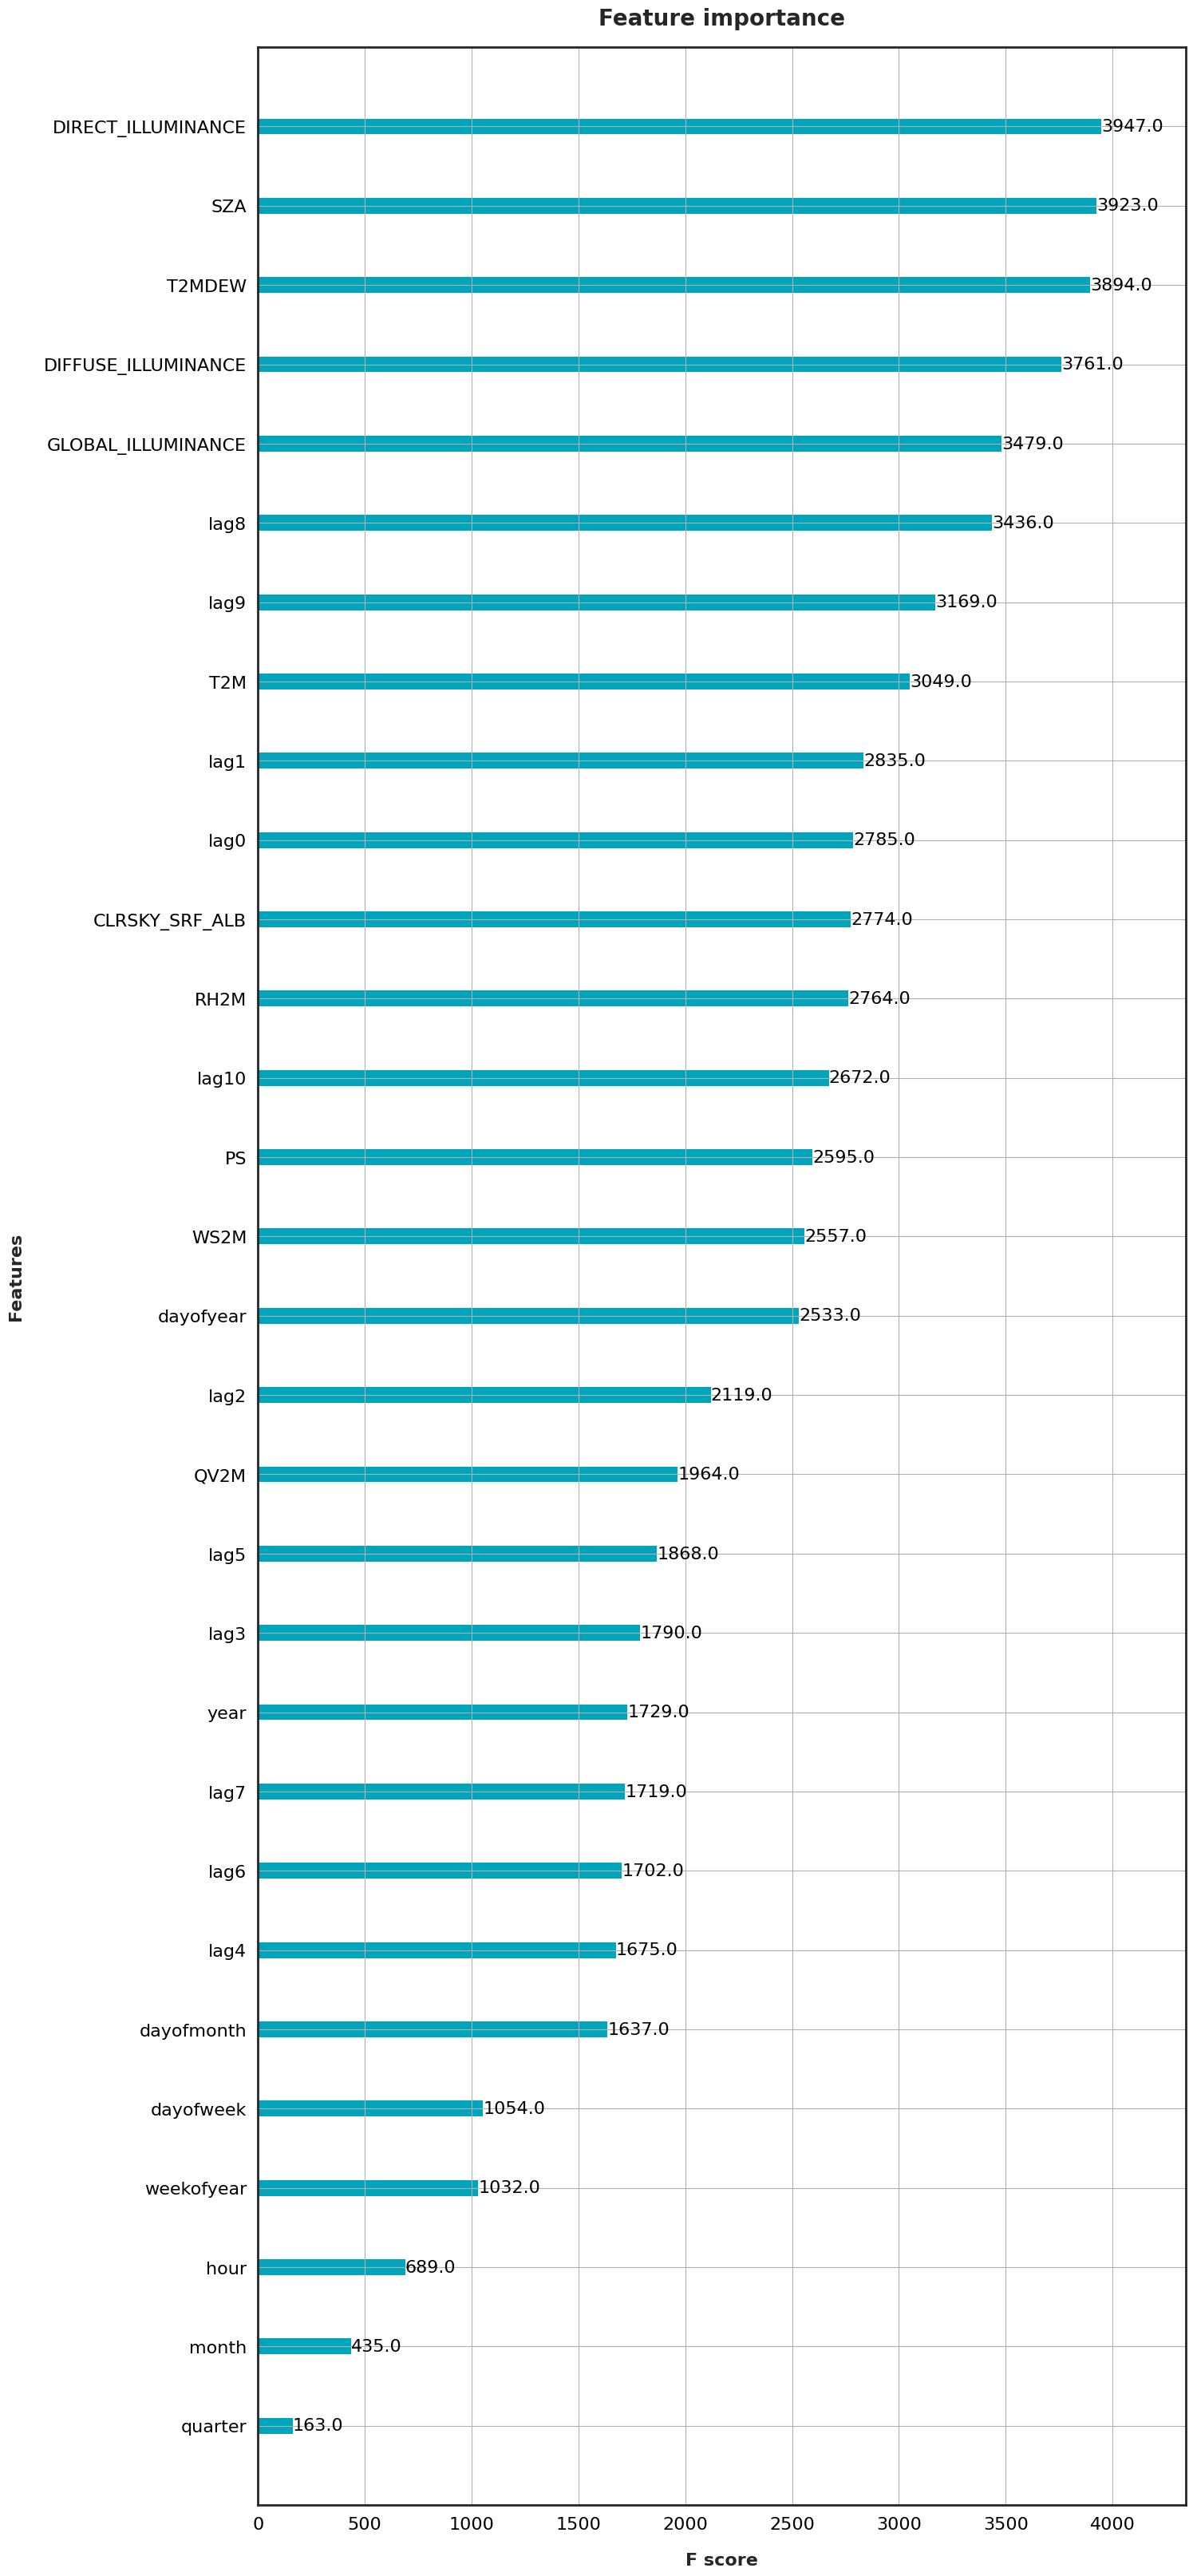

In [18]:
#pd.plotting.register_matplotlib_converters()
xgb.plot_importance(xgbtunedreg);
plt.rcParams['figure.figsize'] = [16, 40];